# PromptChaining Workflow

In [1]:
# !pip install langchain langgraph typing

In [2]:
# !pip install -U langchain langchain-openai

In [3]:
# Importing necessary libraries 

from langgraph.graph import StateGraph, START, END # To created Graph
from langchain.chat_models import init_chat_model # To interact with Models
from typing import TypedDict, List # To create Struct for Graph State
from dotenv import load_dotenv # To load the env variables

load_dotenv()

True

In [4]:
# Creating a Struct using TypedDict to store the state of graph

class BlogState(TypedDict):

    topic : "str"
    outline : "str"
    blog : "str"
    tags : list[str] = []


In [5]:
# Creating just to expirement will use this to pass as a parameter to the get_blog_func function 

# Create an object of init_chat_model class
model = init_chat_model("gpt-5-nano")

In [6]:
# Defining the get_outline_func for the node 1 

def get_outline_func(state : BlogState) -> BlogState:
    
    # I am extracting the topic that the user will provide as input and it will get stored in struct - BlogState
    topic = state["topic"]

    # Once I have extracted the topic - I will draft a prompt here to pass it to model ( Note : I can take prompt as an input too - It can provide flexibility but also can cause issue in quality of output
    prompt = f"Create an outline for this topic = {topic}, Do not use markdown, headings, or extra formatting. - Just output the outline"

    # Now I can pass the prompt to model - but how I can call model here inside the function
    # that's the reason we imported langchain.chat_model 
    # Create an object of init_chat_model class
    model = init_chat_model("gpt-5-nano")

    # I can use the the instance "model" to call function inside the init_chat_model()
    response = model.invoke(prompt)

    # "response" will give a raw response form the invoke model along with other attributes, I just want the response to my prompt not other metadata as of now
    answer = response.content

    # saving the answer to state of graph - updating the state
    state["outline"] = answer

    return state

In [7]:
# Defining the "get_blog_func" for the node 2

def get_blog_func(state : BlogState, model = model) -> BlogState:

    # If we are calling this function, we already must have topic and outline 
    # getting the topic and outline to pass into the next prompt to create the blog 
    topic = state["topic"]
    outline = state["outline"]

    # now we got the parameters , let's create the prompt
    prompt = f"Create a detailed and factually  for this topic = {topic} for this outline = {outline}, Do not use markdown, headings, emoji, icons or extra formatting. - Just output the blog - Ready to post"

    # now passing this prompt to model
    response = model.invoke(prompt)

    # I can use the the instance "model" to call function inside the init_chat_model()
    response = model.invoke(prompt)

    # "response" will give a raw response form the invoke model along with other attributes, I just want the response to my prompt not other metadata as of now
    answer = response.content

    # saving the answer to state of graph - updating the state
    state["blog"] = answer

    return state

In [8]:
# Defining the graph 

# Let's see what's happening here
"""
1. Using "StateGraph" prebuilt class to create an instance of the same class 
2. Passing "BlogState" as a Argument
"""
blog_graph = StateGraph(BlogState)

# Adding Nodes
blog_graph.add_node("get_outline_node", get_outline_func)
blog_graph.add_node("get_blog_node", get_blog_func)

# Adding Edges
blog_graph.add_edge(START, "get_outline_node")
blog_graph.add_edge("get_outline_node", "get_blog_node")
blog_graph.add_edge("get_blog_node", END)

# Compiling the Graph
workflow = blog_graph.compile()

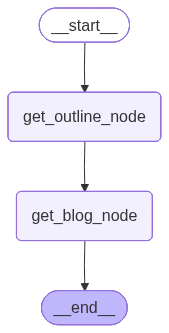

In [9]:
workflow

In [ ]:
input_state = { "topic":"Quantum Computing & Generative AI"}

final_state = workflow.invoke(input_state)